In [14]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate higher MMR code with regimes
- Eccentricities: Depends on MMR / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 3:1, 5:3, 7:5, 4:1, 5:2, 5:1 / Uniform
- Deltas: Depends on MMR / Uniform
- Planet masses: 0.3 to 30 Earth masses / Uniform log m

In [15]:
# Create 50k samples
size = 50000
mstar = 1

# MMR -> j, N Sampling
mmr_list = ['3:1', '5:3', '7:5', '4:1', '5:2', '5:1']
mmr = np.random.choice(mmr_list, size=size)
mmrparts = np.char.split(mmr, ':')  # Extract j:j-N
j = np.array([int(p[0]) for p in mmrparts])
N = np.array([int(p[0]) - int(p[1]) for p in mmrparts])

# Dynamic Delta sampling
mmr_conds = [(mmr == ratio) for ratio in mmr_list]
Delta_mins = [0.010, 0.005, 0.0025, 0.010, 0.005, 0.015]
Delta_maxes = [0.030, 0.015, 0.0075, 0.030, 0.015, 0.030]

Delta_low = np.select(mmr_conds, [mn for mn in Delta_mins], default=0.05)
Delta_high = np.select(mmr_conds, [mx for mx in Delta_maxes], default=0.10)
Delta = np.random.uniform(low=Delta_low, high=Delta_high, size=size) * np.random.choice([-1, 1], size=size)

# Dynamic e sampling
loge_mins = [-1.5, -1.5, -1.7, -1.3, -1.3, -1.0]
loge_low = np.select(mmr_conds, [loge for loge in loge_mins], default=-2)
loge_high = -0.5

e1 = 10 ** np.random.uniform(low=loge_low, high=loge_high, size=size)
e2 = 10 ** np.random.uniform(low=loge_low, high=loge_high, size=size)
w1 = np.random.uniform(low=0, high=360, size=size)
w2 = np.random.uniform(low=0, high=360, size=size)

# Everything else
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-N)

m1 = 10 ** np.random.uniform(low=-0.5, high=1.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=1.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

e_max = np.maximum(e1, e2)
validity1 = Delta**2 / (mu2 * e_max)
validity2 = Delta**2 / (mu1 * e_max)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta,
    'mmr': mmr, 'j': j, 'N': N,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,mmr,j,N,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.130038,158.683884,0.143304,265.026213,-0.017225,5:1,5,4,7,34.397108,3.712095,11.855675,0.000011,0.000036,58.147569,185.711468,False
1,0.185040,326.002355,0.119863,182.119852,0.012900,5:2,5,3,7,17.725747,5.423982,1.036133,0.000016,0.000003,288.975197,55.202372,False
2,0.043906,92.267874,0.260286,160.467138,0.006575,7:5,7,2,7,9.864435,1.681484,12.833617,0.000005,0.000039,4.308848,32.886492,False
3,0.137157,45.617703,0.149986,332.991867,0.018506,4:1,4,3,7,28.518169,0.416515,1.825542,0.000001,0.000005,416.444657,1825.234409,True
4,0.117893,276.395324,0.302893,167.478083,0.017272,5:1,5,4,7,35.604508,0.542796,2.582067,0.000002,0.000008,126.994654,604.110913,True


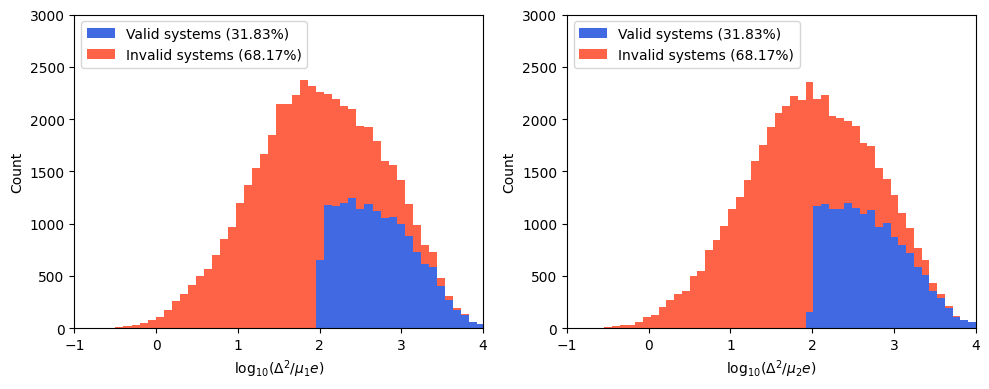

In [18]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-1, 4); ylim = (0, 3000)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
# Export dataframe (Also remove invalid columns to save space)
df[(df.valid == True)].to_csv("deckagol_TTVFast_params.csv", index=False)